In [177]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from tqdm import tqdm
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

%matplotlib inline

In [178]:
import requests
import pandas as pd
from requests.auth import HTTPBasicAuth

endpoint = 'https://www.daloopa.com'
TICKER = 'AMZN'
response = requests.get(f"{endpoint}/api/v1/export/{TICKER}",auth=HTTPBasicAuth('jedgore1@gmail.com',''),stream=True)

df = pd.read_csv(response.raw)


In [179]:
df.to_csv('data.csv')

In [180]:
df = pd.read_csv('data.csv')
df = df[df['span']=='quarterly']
df[df['label'].str.contains('net sales')]

,Unnamed: 0,id,ticker,company_name,label,category,span,calendar_period,fiscal_period,fiscal_date,...,value_normalized,source_link,series_id,filing_date,series_id_relations,series_tag,restated,title,capiq_ticker,is_transition_period
2526,2526,768402,AMZN,Amazon Com Inc,Electronics and other general merchandise - TT...,Geographical breakdown,quarterly,2013Q1,2013Q1,2013-03-31,...,0.670,https://www.daloopa.com/src/768402,85950,2013-04-25,NaN,NaN,False,Geographical breakdown | North America segment...,NasdaqGS:AMZN,False
2527,2527,768255,AMZN,Amazon Com Inc,Electronics and other general merchandise - TT...,Geographical breakdown,quarterly,2013Q2,2013Q2,2013-06-30,...,0.670,https://www.daloopa.com/src/768255,85950,2013-07-25,NaN,NaN,False,Geographical breakdown | North America segment...,NasdaqGS:AMZN,False
2528,2528,768110,AMZN,Amazon Com Inc,Electronics and other general merchandise - TT...,Geographical breakdown,quarterly,2013Q3,2013Q3,2013-09-30,...,0.670,https://www.daloopa.com/src/768110,85950,2013-10-24,NaN,NaN,False,Geographical breakdown | North America segment...,NasdaqGS:AMZN,False
2529,2529,767949,AMZN,Amazon Com Inc,Electronics and other general merchandise - TT...,Geographical breakdown,quarterly,2013Q4,2013Q4,2013-12-31,...,0.670,https://www.daloopa.com/src/767949,85950,2014-01-30,NaN,NaN,False,Geographical breakdown | North America segment...,NasdaqGS:AMZN,False
2530,2530,767710,AMZN,Amazon Com Inc,Electronics and other general merchandise - TT...,Geographical breakdown,quarterly,2014Q1,2014Q1,2014-03-31,...,0.670,https://www.daloopa.com/src/767710,85950,2014-04-24,NaN,NaN,False,Geographical breakdown | North America segment...,NasdaqGS:AMZN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5353,5353,46660911,AMZN,Amazon Com Inc,Total net sales,Income statement,quarterly,2021Q4,2021Q4,2021-12-31,...,137412.000,https://www.daloopa.com/src/46660911,86081,2022-02-03,NaN,NaN,False,Income statement | Total net sales,NasdaqGS:AMZN,False
5355,5355,53637819,AMZN,Amazon Com Inc,Total net sales,Income statement,quarterly,2022Q1,2022Q1,2022-03-31,...,116444.000,https://www.daloopa.com/src/53637819,86081,2022-03-31,NaN,NaN,False,Income statement | Total net sales,NasdaqGS:AMZN,False
5356,5356,58837652,AMZN,Amazon Com Inc,Total net sales,Income statement,quarterly,2022Q2,2022Q2,2022-06-30,...,121234.000,https://www.daloopa.com/src/58837652,86081,2022-07-28,NaN,NaN,False,Income statement | Total net sales,NasdaqGS:AMZN,False
5357,5357,63129644,AMZN,Amazon Com Inc,Total net sales,Income statement,quarterly,2022Q3,2022Q3,2022-09-30,...,127101.000,https://www.daloopa.com/src/63129644,86081,2022-10-27,NaN,NaN,False,Income statement | Total net sales,NasdaqGS:AMZN,False


In [181]:
df = df.loc[df['span']=='quarterly']
df = df.loc[df['series_id']==86081] #value
cols = ['fiscal_date','value_raw']
df = df[cols]
df.columns = ['date','data']
print(f"length: {len(df)}")
df.tail()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

length: 40


In [182]:
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.2602467767113963
p-value: 0.9963768093454262


In [183]:
value_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(value_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


ADF Statistic: -2.0813716011307686
p-value: 0.252070843142264


In [185]:
value_diff2 = np.diff(value_diff, n=1)

ad_fuller_result = adfuller(value_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.065342337052207
p-value: 1.645197187942267e-05


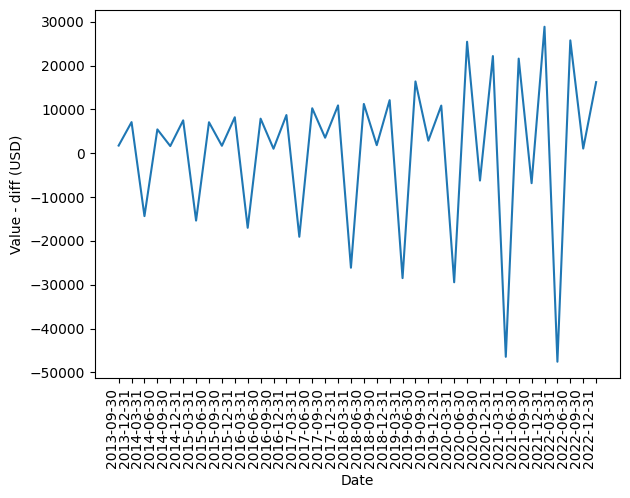

In [202]:


fig, ax = plt.subplots()

ax.plot(df['date'][2:], value_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Value - diff (USD)')

fig.autofmt_xdate()
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()



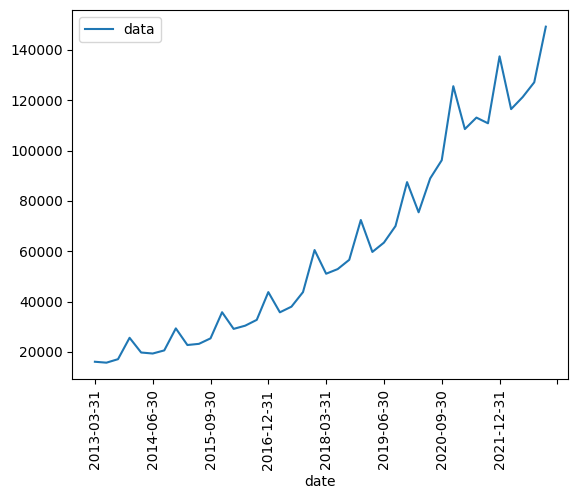

In [187]:
df.plot(x='date',y='data')
plt.xticks(rotation=90)
plt.show()


In [188]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    #for order in tqdm_notebook(order_list):
    for order in order_list:

        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [189]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

In [190]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

,"(p,q)",AIC
0,"(3, 0)",694.031
1,"(3, 1)",696.066
2,"(3, 3)",700.371
3,"(3, 2)",711.349
4,"(0, 2)",721.657
5,"(1, 2)",723.573
6,"(2, 3)",724.277
7,"(2, 2)",725.616
8,"(1, 3)",726.188
9,"(1, 1)",727.691


In [191]:
model = SARIMAX(train, order=(3,2,0), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   36
Model:               SARIMAX(3, 2, 0)   Log Likelihood                -343.016
Date:                Fri, 10 Mar 2023   AIC                            694.031
Time:                        12:36:38   BIC                            700.136
Sample:                             0   HQIC                           696.113
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9939      0.060    -16.498      0.000      -1.112      -0.876
ar.L2         -0.9380      0.106     -8.829      0.000      -1.146      -0.730
ar.L3         -0.9440      0.063    -14.971      0.0

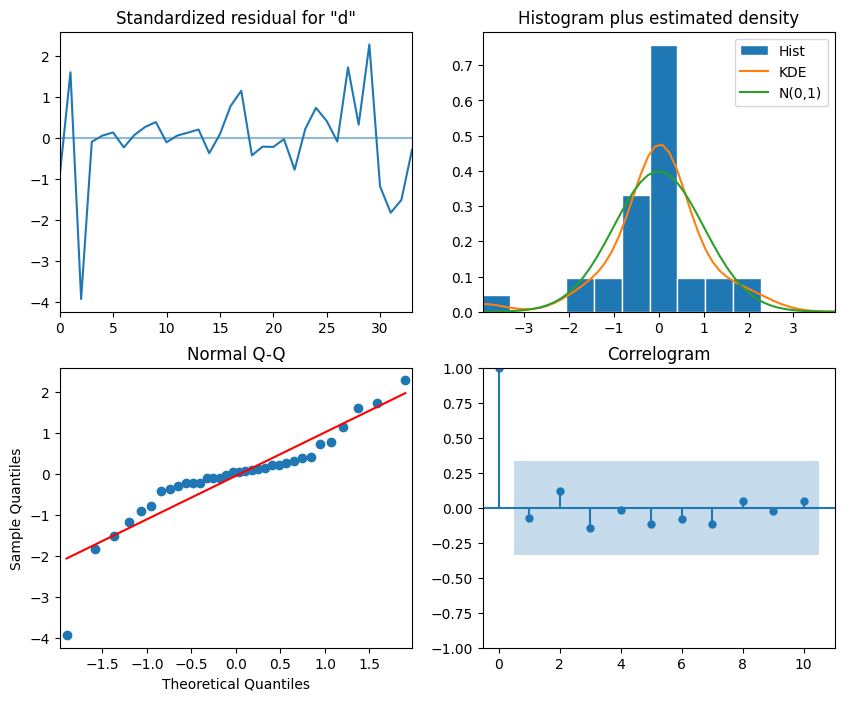

In [192]:
model_fit.plot_diagnostics(figsize=(10,8));


In [193]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [194]:
test = df.iloc[-4:]
test['naive_seasonal'] = df['data'].iloc[32:36].values

In [195]:
test

,date,data,naive_seasonal
5355,2022-03-31,116444.000,108518.000
5356,2022-06-30,121234.000,113080.000
5357,2022-09-30,127101.000,110812.000
5358,2022-12-31,149204.000,137412.000


In [196]:
ARIMA_pred = model_fit.get_prediction().predicted_mean[32:36]
test['ARIMA_pred'] = ARIMA_pred.values
test

,date,data,naive_seasonal,ARIMA_pred
5355,2022-03-31,116444.000,108518.000,114742.649
5356,2022-06-30,121234.000,113080.000,122723.389
5357,2022-09-30,127101.000,110812.000,118804.319
5358,2022-12-31,149204.000,137412.000,138920.261


In [197]:
df_plot = pd.merge(df,test,how = 'outer')
df_plot.tail()

,date,data,naive_seasonal,ARIMA_pred
35,2021-12-31,137412.000,NaN,NaN
36,2022-03-31,116444.000,108518.000,114742.649
37,2022-06-30,121234.000,113080.000,122723.389
38,2022-09-30,127101.000,110812.000,118804.319
39,2022-12-31,149204.000,137412.000,138920.261


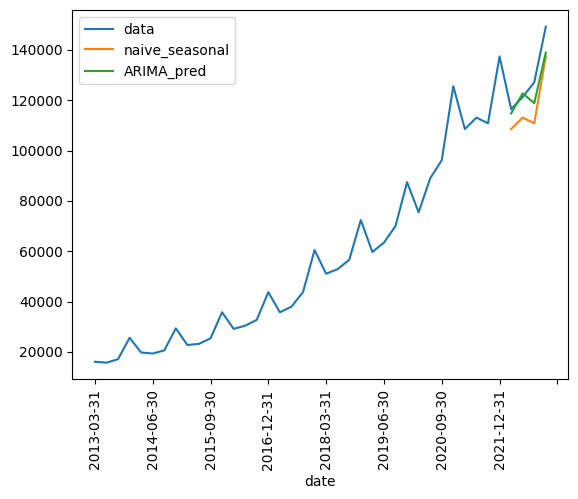

In [198]:
import matplotlib.pyplot as plt

df_plot.plot(x="date", y=["data", "naive_seasonal",'ARIMA_pred'])
plt.xticks(rotation=90)
plt.show()

In [199]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [200]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

8.562901722920468 4.027410995128344


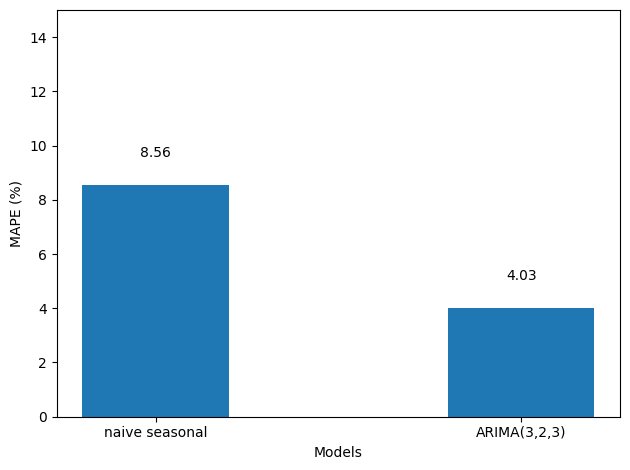

In [201]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

